# COMP135 Project 02
### Shaikat Islam

#### Import data into Google Colab

In [0]:
from google.colab import files
uploaded = files.upload()

Saving x_test.csv to x_test.csv
Saving x_train.csv to x_train.csv
Saving y_train.csv to y_train.csv


In [0]:
uploaded = files.upload()

Saving glove.6B.50d.txt to glove.6B.50d.txt


### 0.0 - Loading and Preprocessing Data

Data was loaded using pandas, and preprocessed. I used the Natural Language ToolKit (nltk) to preprocess the data. First, I converted all the sentences to lowercase. After that, I handled contractions (words with apostrophes in them) by converting them into a form without apostrophes, as defined within the dictionary named 'appos' (taken from the comments section in a vidhy blog). After this, I removed all the stop words (commonly occurring words which are not relevant in the context of the data), using nltk's stopwords dictionary. After this, I removed punctuation from the words. Finally, I used lemmatization to convert all the words in a sentence to their base form (lemma), which removes inflection and determines the part of speech.

In [0]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

x_train_df = pd.read_csv('x_train.csv')
y_train_df = pd.read_csv('y_train.csv')

# Check that data has actually been loaded into Google Colab.
tr_text_list = x_train_df['text'].values.tolist()
print(tr_text_list[15])

# Get vocab count 
cv = CountVectorizer()
word_count_vector = cv.fit_transform(tr_text_list)
print(word_count_vector.shape)
# appos to be used in preprocessing
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

# Preprocess Data
def preprocess(review_arr):
  processed = []

  # case characters by converting them all to lowercase
  for text in review_arr:
    processed.append(text.lower())

  # negation handling by converting apostrophes to standard lexicon 
  negation = []
  for text in processed:
    words = text.split()
    reformed = [appos[word] if word in appos else word for word in words]
    reformed = " ".join(reformed)
    negation.append(reformed)

  # tokenize data by converting text to tokens
  tokenized = []
  for text in negation:
    tokenized.append(word_tokenize(text))

  # remove stopwords from sentences (words that are most commonly occurring, but not
  # relevant in the context of the data)
  # we use english stopwords here, which may not be relevant in the context of foreign words
  stop_words = set(stopwords.words('english'))
  for text in tokenized:
    text = [i for i in text if not i in stop_words]
  
  # remove stand-alone punctuation
  stripped = []
  for text in tokenized:
    words = [word for word in text if word.isalpha()]
    stripped.append(words)

  # stemming/lemmatization finds the base or dictionary form of the word known as the lemma
  # using vocabulary and morphological analysis
  # use gensim package -- which takes into account part-of-speech as well.
  lemmas = []
  porter = PorterStemmer()
  for text in stripped:
    lemmafied = []
    for t in text:
      lemmafied.append(porter.stem(t))
    lemmas.append(lemmafied)

  return lemmas
  
p = preprocess(tr_text_list)
print(p[15])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Don't make the same mistake I did.
(2400, 4510)
['do', 'not', 'make', 'the', 'same', 'mistak', 'i', 'did']


### 1.1 Vectorizing Preprocessed Reviews to Feature Vectors Using Bag of Words Model and TF-IDF 

For the vectorization process, I decided to use sklearn's TfidVectorizer and TfidTransformer classes. Before any preprocessing, the input training data set initially had 4510 unique words, and the test data set had 1921. After preprocessing, which included the removal of stop words, conversion of contractions, and removal of punctuation, the vocabulary size decreased to 3414 words. There is no real order to these words, as there is no link from the words in these reviews in the training and test sets to any parts of speech -- further work would be required to determine the part of speech, perhaps using a Conditional Random Fields (CRF) model, which uses probability to determine part of speech. I do not exclude rare words, nor do I exclude common words. I do exclude stop words, which are words that are mostly commonly occurring, but not
relevant in the context of the data, as determined by nltk's stopwords dictionary. Because I use the TfidTransformer and TfidVectorizer, common words are penalized, as I use the inverse document frequency (IDF) multiplied by the term frequency (TF) as the "count" for each feature vector. I also only use single features.

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer()

# feature transform training set
x_tr_pre = preprocess(tr_text_list)
x_tr = []
for text in x_tr_pre:
  sentence = " ".join(text)
  x_tr.append(sentence)
x_train = vectorizer.fit_transform(x_tr)

tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))



# feature transform testing set
x_test_df = pd.read_csv('x_test.csv')
te_text_list = x_test_df['text'].values.tolist()
x_te_pre = preprocess(te_text_list)
x_te = [] 
for text in x_te_pre:
  sentence = " ".join(text)
  x_te.append(sentence)
x_test = vectorizer.transform(x_te)
print(x_train.shape, x_test.shape)

(2400, 3414) (600, 3414)


### 1.2 Logistic Regression Model for Bag-of-Words


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


BEST SCORE: 
0.81875
STANDARD DEVIATIONS
[0.03578    0.02763854 0.03165022 0.02871677 0.02825971 0.02977345
 0.01545603 0.02904738 0.01171122 0.02822897 0.00962852 0.02190573
 0.00962852 0.02138438 0.01801812 0.01929306 0.01755942 0.02021585
 0.01352724 0.01974666 0.02162657 0.01884697 0.01942757 0.01577841]
STANDARD DEVIATION FOR BEST SCORE:
0.0287167682335213


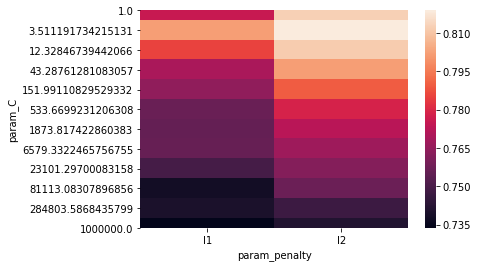

In [0]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
import seaborn as sns

logreg = LogisticRegression()
# Grid Search for Hyperparameters
penalty = ['l1', 'l2']
C = np.logspace(0, 6, 12)
hyperparams = dict(C=C, penalty=penalty)
clf = GridSearchCV(logreg, hyperparams, cv=5, verbose=0)
clf.fit(x_train, y_train_df)
print("BEST SCORE: ")
print(clf.best_score_)
print("STANDARD DEVIATIONS")
print(clf.cv_results_['std_test_score'])
print("STANDARD DEVIATION FOR BEST SCORE:")
print(clf.cv_results_['std_test_score'][clf.best_index_])

pivot = pd.pivot_table(pd.DataFrame(clf.cv_results_), values='mean_test_score', index='param_C', columns='param_penalty')
ax = sns.heatmap(pivot)

### 1.3 Multilayer Perceptron (MLP) Model with Bag-Of-Words

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

mlp = MLPClassifier(max_iter=120)

hyperparams = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (256,)],
    'activation': ['identity','logistic', 'relu', 'tanh'],
}

clf_mlp = GridSearchCV(mlp, hyperparams, cv=5, verbose=0)
clf_mlp.fit(x_train, y_train_df.values.ravel()) 
print("BEST SCORE: ")
print(clf_mlp.best_score_)
print("STANDARD DEVIATIONS")
print(clf_mlp.cv_results_['std_test_score'])
print("STANDARD DEVIATION FOR BEST SCORE:")
print(clf_mlp.cv_results_['std_test_score'][clf_mlp.best_index_])

pivot_mlp = pd.pivot_table(pd.DataFrame(clf_mlp.cv_results_), values='mean_test_score', index='param_hidden_layer_sizes', columns='param_activation')


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

BEST SCORE: 
0.795
STANDARD DEVIATIONS
[0.02505549 0.02466441 0.02388485 0.02312406 0.02420256 0.01860593
 0.0192119  0.02468552 0.01838062 0.02060711 0.02055649 0.02032718
 0.02405867 0.02362173 0.02648375 0.02051422]
STANDARD DEVIATION FOR BEST SCORE:
0.019211903138997517


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


NameError: ignored

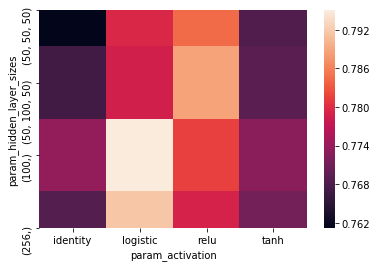

In [0]:
ax_mlp = sns.heatmap(pivot_mlp)

### 1.3 K Nearest Neighbors with Bag-Of-Words

BEST SCORE: 
0.7629166666666667
STANDARD DEVIATIONS
[0.01144128 0.01144128 0.07474958 0.07526112 0.02698379 0.02757565
 0.00805795 0.00870026 0.00618017 0.00552771 0.01333333 0.0124024
 0.01502313 0.01427653 0.01803738 0.01743042 0.0164781  0.0152525
 0.02060711 0.01983438 0.02186607 0.02008662 0.02207154 0.02079162
 0.03080517 0.02225952 0.0209165  0.01902119]
STANDARD DEVIATION FOR BEST SCORE:
0.02008661798865659


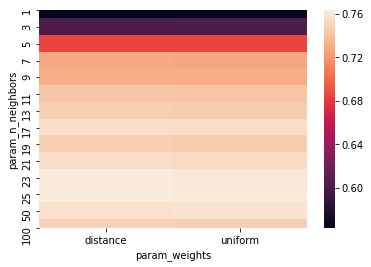

In [0]:
from sklearn.neighbors import KNeighborsClassifier

hyperparams = {
    'n_neighbors' : [1,3,5,7,9,11,13,17,19,21,23,25,50,100],
    'weights' : ['uniform', 'distance']
    }

clf_knn = GridSearchCV(KNeighborsClassifier(), hyperparams, cv=5, verbose=0)
clf_knn.fit(x_train, y_train_df.values.ravel()) 
print("BEST SCORE: ")
print(clf_knn.best_score_)
print("STANDARD DEVIATIONS")
print(clf_knn.cv_results_['std_test_score'])
print("STANDARD DEVIATION FOR BEST SCORE:")
print(clf_knn.cv_results_['std_test_score'][clf_knn.best_index_])

pivot_knn = pd.pivot_table(pd.DataFrame(clf_knn.cv_results_), values='mean_test_score', index='param_n_neighbors', columns='param_weights',)
ax_knn = sns.heatmap(pivot_knn)

from google.colab import files
yproba1_test = clf_knn.predict_proba(x_test)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)
files.download('yproba1_test.txt')


### 1.5 - Summary of Results

The best performing classifier has been the Logistic Regression classifier, to my surprise. I initially thought that it would be very unlikely that the Logistic Regression model would give me the best results, as it seemed very straightforward -- that seemed to work in its favor, however. More complicated models such as the multilayer perceptron classifier performed worse, and the K-Nearest Neighbor model also performed the worst of them all. I believe a large part of this success has to do with the feature tuning performed -- by so rigorously trying to normalize the input data into feature vectors using TF-IDF, it seems to me that the Logistic Regression classifier worked the best as it usually performs the best when attributes unrelated to the output variable, as well as closely related attributes are removed from the input set. This was most perceptible within the steps of removing stop words (unrelated attributes to the feature set), and the TF-IDF vectorization (penalizing closely related attributes). In combination with the regularization performed on the model, it seems that normalizing the data did make the output classes rather separable.

Using a KNN model may have not been as suited for this task as the number of output classes was limited to 2. Possible reasons for why the KNN model and MLP model may have not worked as best, or in conjunction with my original hypothesis, may also be as a consequence of underfitting, and a lack of greater parameter tuning (which may have resulted in better performance.)

The logistic regression model did best on predicting positive values with data sourced from Amazon, with a true positive rate of .9675, compared to .9475 and .935 for Yelp and IMDb, respectively. The model predicted true negatives est fro Yelp reviews, with a true negative rate of 0.98, compared to .9775 and .9725 for Amazon and IMDb, respectively. The model also had a higher false positive rate for Yelp reviews, at a false positive rate of 0.0525, compared to 0.0325 and 0.065 for Amazon and IMDb reviews. Interestingly, it also had the lowest true negative rates for Yelp reviews, at 0.02, compared to 0.0225 and 0.275 for Amazon and IMDb, respectively. Overall, in terms of total accuracy, the model perofrmed best on Amazon reviews, at an accuracy of 0.9725, compared to 0.96375 and 0.95375 for Yelp and IMDb, respectively. Possible reasons for this may be due to the number of sentimental (positive/negative) words within the feature sets for each type of review -- Amazon customers may have better use of language in line with how the model calculates an output class for sentiment, but conversely, my model may also overfit for Amazon reviews.

### 1.6 Applying Best Classifier to Leaderboard

Using the test set on the GradeScope leaderboard, the logistic regression model gave an error rate of 0.16167 and an AUROC of 0.9061, putting me 11th place on the leaderboard at the time of writing (out of 64). This matches up with what the training set performance eluded to, given that both the training set and the test set had the best performance compared to the other classfiers. This may suggest that the testing data may be similar in terms of tf-idf values with the training data, and the Logistic Regression model may have overfit on the training data, leading to an increased performance on the testing data (which is similar, in this case). It could also mean that the other models overfit on training data, which in this scenario, is not as similar in comparison to the testing data. 

In [0]:
tr_web_list = x_train_df['website_name'].values.tolist()
rst = clf.predict(x_train)

amazon_p = 0
yelp_p = 0
imdb_p = 0
amazon_n = 0
yelp_n = 0
imdb_n = 0

amazon_tp = 0
yelp_tp = 0
imdb_tp = 0
amazon_tn = 0
yelp_tn = 0
imdb_tn = 0

amazon_fp = 0
yelp_fp = 0
imdb_fp = 0
amazon_fn = 0
yelp_fn = 0
imdb_fn = 0

amazon_avg_rev = 0
yelp_avg_rev = 0
imdb_avg_rev = 0

for i in range(0,2400):
  if tr_web_list[i] == "amazon":
    amazon_avg_rev+=x_train[i].shape[0]
  elif tr_web_list[i] == "yelp":
    yelp_avg_rev+=x_train[i].shape[0]
  elif tr_web_list[i] == "imdb":
    imdb_avg_rev+=x_train[i].shape[0]

amazon_avg_rev = amazon_avg_rev/2400
yelp_avg_rev = yelp_avg_rev/2400
imdb_avg_rev = imdb_avg_rev/2400

for i in range(0,2400):
  if y_train_df.values[i] == 1 and tr_web_list[i] == "amazon":
    amazon_p+=1
  elif y_train_df.values[i] == 1 and tr_web_list[i] == "yelp":
    yelp_p+=1
  elif y_train_df.values[i] == 1 and tr_web_list[i] == "imdb":
    imdb_p+=1
  elif y_train_df.values[i] == 0 and tr_web_list[i] == "amazon":
    amazon_n+=1
  elif y_train_df.values[i] == 0 and tr_web_list[i] == "yelp":
    yelp_n+=1
  elif y_train_df.values[i] == 0 and tr_web_list[i] == "imdb":
    imdb_n+=1

for i in range(0,2400):
  if rst[i] == 1 and y_train_df.values[i] == 1 and tr_web_list[i] == "amazon":
    amazon_tp+=1
  elif rst[i] == 1 and y_train_df.values[i] == 1 and tr_web_list[i] == "yelp":
    yelp_tp+=1
  elif rst[i] == 1 and y_train_df.values[i] == 1 and tr_web_list[i] == "imdb":
    imdb_tp+=1
  elif rst[i] == 0 and y_train_df.values[i] == 0 and tr_web_list[i] == "amazon":
    amazon_tn+=1
  elif rst[i] == 0 and y_train_df.values[i] == 0 and tr_web_list[i] == "yelp":
    yelp_tn+=1
  elif rst[i] == 0 and y_train_df.values[i] == 0 and tr_web_list[i] == "imdb":
    imdb_tn+=1
  elif rst[i] == 1 and y_train_df.values[i] == 0 and tr_web_list[i] == "amazon":
    amazon_fn+=1
  elif rst[i] == 1 and y_train_df.values[i] == 0 and tr_web_list[i] == "yelp":
    yelp_fn+=1
  elif rst[i] == 1 and y_train_df.values[i] == 0 and tr_web_list[i] == "imdb":
    imdb_fn+=1
  elif rst[i] == 0 and y_train_df.values[i] == 1 and tr_web_list[i] == "amazon":
    amazon_fp+=1
  elif rst[i] == 0 and y_train_df.values[i] == 1 and tr_web_list[i] == "yelp":
    yelp_fp+=1
  elif rst[i] == 0 and y_train_df.values[i] == 1 and tr_web_list[i] == "imdb":
    imdb_fp+=1

print("OVERALL ACCURACY")
print(".81875")
print("AMAZON ACCURACY")
print(str((amazon_tp+amazon_tn)/(amazon_n+amazon_p)))
print("YELP ACCURACY")
print(str((yelp_tp+yelp_tn)/(yelp_n+yelp_p)))
print("IMDB ACCURACY")
print(str((imdb_tp+imdb_tn)/(imdb_n+imdb_p)))
print("AMAZON TRUE POSITIVE")
print(str((amazon_tp)/(amazon_p)))
print("YELP TRUE POSITIVE")
print(str((yelp_tp)/(yelp_p)))
print("IMDB TRUE POSITIVE")
print(str((imdb_tp)/(imdb_p)))
print("AMAZON TRUE NEGATIVE")
print(str((amazon_tn)/(amazon_n)))
print("YELP TRUE NEGATIVE")
print(str((yelp_tn)/(yelp_n)))
print("IMDB TRUE NEGATIVE")
print(str((imdb_tn)/(imdb_n)))
print("AMAZON FALSE POSITIVE")
print(str((amazon_fp)/(amazon_p)))
print("YELP FALSE POSITIVE")
print(str((yelp_fp)/(yelp_p)))
print("IMDB FALSE POSITIVE")
print(str((imdb_fp)/(imdb_p)))
print("AMAZON FALSE NEGATIVE")
print(str((amazon_fn)/(amazon_n)))
print("YELP FALSE NEGATIVE")
print(str((yelp_fn)/(yelp_n)))
print("IMDB FALSE NEGATIVE")
print(str((imdb_fn)/(imdb_n)))

NameError: ignored

### 2.1 Pipeline for Classifying Review Sentiment with Word Embeddings

First, I preprocessed the data in the same way mentioned, in detail, in section 1.1.

Since GloVE provides a 50 dimension feature vector for each word, I figured that a good way to vectorize reviews would be to average all the words within the reviews. I thought it best to use the average of all the feature vectors in order to standardize the input data based on varying input feature length. By simply summing and concatenating feature vectors, discrepancies in length are not handled properly. After averaging all the values, I felt that it was relevant to weigh the feature vectors by multiplying the feature vectors by the TF-IDF weight, calculated using sklearn's TfidfVectorizer(). This time, each feature vector has 50 dimensions instead of 3414, due to the limit in dimensionality of the word embedding dataset being used.


In [0]:
import pandas as pd
import numpy as np

from collections import OrderedDict

word_embeddings = pd.read_csv('glove.6B.50d.txt',
                               header=None, sep=' ', index_col=0,
                               nrows=100000, encoding='utf-8', quoting=3)
# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))

def vectorizer(sentence):
  sent_vec = np.zeros(50)
  numw = 0
  for w in sentence:
    try: 
      vc = word2vec[w]
      vc = [i * tfidf[w] for i in vc]
      vc=vc[0:50]
      sent_vec = np.add(sent_vec, vc)
      numw+=1
    except:
      pass
  return sent_vec / np.sqrt(sent_vec.dot(sent_vec))

X_train_pre = []
for sentence in preprocess(tr_text_list):
  X_train_pre.append(vectorizer(sentence))

X_train = []
for sentence in X_train_pre:
  arr = []
  for word in sentence:
    if np.isnan(word):
      arr.append(0)
    else:
      arr.append(word)
  X_train.append(arr)

x_train = np.array(X_train)

X_test_pre = []
te_text_list = x_test_df['text'].values.tolist()
for sentence in preprocess(te_text_list):
  X_test_pre.append(vectorizer(sentence))

X_test = []
for sentence in X_test_pre:
  arr = []
  for word in sentence:
    if np.isnan(word):
      arr.append(0)
    else:
      arr.append(word)
  X_test.append(arr)

x_test = np.array(X_test)

print(x_test.shape)
print(x_train.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


(600, 50)
(2400, 50)


### 2.2 Logistic Regression and Word Embeddings

Error Rate: 0.295	 AUROC: 0.77871
62/64


BEST SCORE: 
0.71625
STANDARD DEVIATIONS
[0.02214222 0.01942757 0.02519369 0.02138438 0.02354812 0.02624008
 0.02220485 0.02322146 0.02433134 0.02169069 0.02348167 0.02402978
 0.02325881 0.02283698 0.02325881 0.02322146 0.02325881 0.02322146
 0.02325881 0.02322146 0.02325881 0.02322146 0.02325881 0.02322146]
STANDARD DEVIATION FOR BEST SCORE:
0.01942757204479128


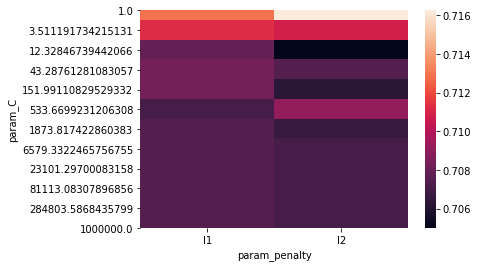

In [0]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
import seaborn as sns

logreg = LogisticRegression(solver='liblinear')
# Grid Search for Hyperparameters
penalty = ['l1', 'l2']
C = np.logspace(0, 6, 12)
hyperparams = dict(C=C, penalty=penalty)
clf = GridSearchCV(logreg, hyperparams, cv=5, verbose=0)
clf.fit(x_train, y_train_df.values.ravel())
print("BEST SCORE: ")
print(clf.best_score_)
print("STANDARD DEVIATIONS")
print(clf.cv_results_['std_test_score'])
print("STANDARD DEVIATION FOR BEST SCORE:")
print(clf.cv_results_['std_test_score'][clf.best_index_])

pivot = pd.pivot_table(pd.DataFrame(clf.cv_results_), values='mean_test_score', index='param_C', columns='param_penalty')
ax = sns.heatmap(pivot)

In [0]:
from google.colab import files
yproba1_test = clf.predict_proba(x_test)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)
files.download('yproba1_test.txt')

### 2.3 Multilayer Perceptrons (MLP) and Word Embeddings

Error Rate: 0.27667	AUROC: 0.79791
62/64




In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

mlp = MLPClassifier(max_iter=120)

hyperparams = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (256,)],
    'activation': ['identity','logistic', 'relu', 'tanh'],
}

clf_mlp = GridSearchCV(mlp, hyperparams, cv=5, verbose=0)
clf_mlp.fit(x_train, y_train_df.values.ravel()) 
print("BEST SCORE: ")
print(clf_mlp.best_score_)
print("STANDARD DEVIATIONS")
print(clf_mlp.cv_results_['std_test_score'])
print("STANDARD DEVIATION FOR BEST SCORE:")
print(clf_mlp.cv_results_['std_test_score'][clf_mlp.best_index_])

pivot_mlp = pd.pivot_table(pd.DataFrame(clf_mlp.cv_results_), values='mean_test_score', index='param_hidden_layer_sizes', columns='param_activation')


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

BEST SCORE: 
0.71375
STANDARD DEVIATIONS
[0.0295804  0.02498611 0.02344467 0.02729087 0.02166667 0.02417385
 0.02391391 0.02       0.03105215 0.02445943 0.0353406  0.03721186
 0.02332589 0.02402978 0.02318405 0.02422407]
STANDARD DEVIATION FOR BEST SCORE:
0.03721185593627686


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


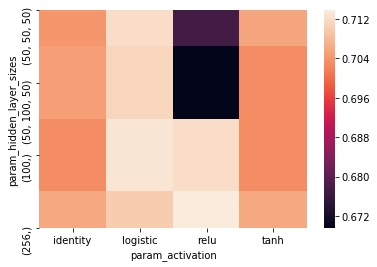

In [0]:
ax = sns.heatmap(pivot_mlp)
from google.colab import files
yproba1_test = clf_mlp.predict_proba(x_test)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)
files.download('yproba1_test.txt')

### 2.4 Support Vector Machines and Word Embedding


> Indented block


Error: 0.28333	Auroc: 0.78988 64/66

In [0]:
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
import seaborn as sns

svc = SVC(probability=True)
hyperparams = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma' : [0.001, 0.01, 0.1, 1]
}
clf_svc = GridSearchCV(svc, hyperparams, cv=5, verbose=0)
clf_svc.fit(x_train, y_train_df.values.ravel()) 
print("BEST SCORE: ")
print(clf_svc.best_score_)
print("STANDARD DEVIATIONS")
print(clf_svc.cv_results_['std_test_score'])
print("STANDARD DEVIATION FOR BEST SCORE:")
print(clf_svc.cv_results_['std_test_score'][clf_svc.best_index_])

pivot_mlp = pd.pivot_table(pd.DataFrame(clf_svc.cv_results_), values='mean_test_score', index='param_C', columns='param_gamma')


BEST SCORE: 
0.7158333333333333
STANDARD DEVIATIONS
[0.02666667 0.02811805 0.02968001 0.03013281 0.02666667 0.02811805
 0.02968001 0.03013281 0.02666667 0.02811805 0.02968001 0.02827813
 0.02666667 0.02811805 0.02428134 0.02276846 0.02666667 0.02365845
 0.0225     0.02462919]
STANDARD DEVIATION FOR BEST SCORE:
0.02276846015385707


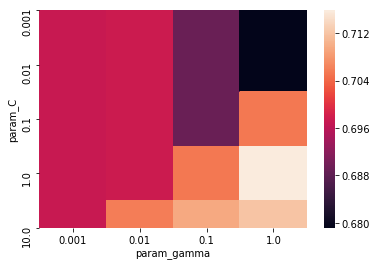

In [0]:
ax = sns.heatmap(pivot_mlp)
from google.colab import files
yproba1_test = clf_svc.predict_proba(x_test)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)
files.download('yproba1_test.txt')

In [0]:
tr_web_list = x_train_df['website_name'].values.tolist()
rst = clf.predict(x_train)

amazon_p = 0
yelp_p = 0
imdb_p = 0
amazon_n = 0
yelp_n = 0
imdb_n = 0

amazon_tp = 0
yelp_tp = 0
imdb_tp = 0
amazon_tn = 0
yelp_tn = 0
imdb_tn = 0

amazon_fp = 0
yelp_fp = 0
imdb_fp = 0
amazon_fn = 0
yelp_fn = 0
imdb_fn = 0

amazon_avg_rev = 0
yelp_avg_rev = 0
imdb_avg_rev = 0

for i in range(0,2400):
  if tr_web_list[i] == "amazon":
    amazon_avg_rev+=x_train[i].shape[0]
  elif tr_web_list[i] == "yelp":
    yelp_avg_rev+=x_train[i].shape[0]
  elif tr_web_list[i] == "imdb":
    imdb_avg_rev+=x_train[i].shape[0]

amazon_avg_rev = amazon_avg_rev/2400
yelp_avg_rev = yelp_avg_rev/2400
imdb_avg_rev = imdb_avg_rev/2400

for i in range(0,2400):
  if y_train_df.values[i] == 1 and tr_web_list[i] == "amazon":
    amazon_p+=1
  elif y_train_df.values[i] == 1 and tr_web_list[i] == "yelp":
    yelp_p+=1
  elif y_train_df.values[i] == 1 and tr_web_list[i] == "imdb":
    imdb_p+=1
  elif y_train_df.values[i] == 0 and tr_web_list[i] == "amazon":
    amazon_n+=1
  elif y_train_df.values[i] == 0 and tr_web_list[i] == "yelp":
    yelp_n+=1
  elif y_train_df.values[i] == 0 and tr_web_list[i] == "imdb":
    imdb_n+=1

for i in range(0,2400):
  if rst[i] == 1 and y_train_df.values[i] == 1 and tr_web_list[i] == "amazon":
    amazon_tp+=1
  elif rst[i] == 1 and y_train_df.values[i] == 1 and tr_web_list[i] == "yelp":
    yelp_tp+=1
  elif rst[i] == 1 and y_train_df.values[i] == 1 and tr_web_list[i] == "imdb":
    imdb_tp+=1
  elif rst[i] == 0 and y_train_df.values[i] == 0 and tr_web_list[i] == "amazon":
    amazon_tn+=1
  elif rst[i] == 0 and y_train_df.values[i] == 0 and tr_web_list[i] == "yelp":
    yelp_tn+=1
  elif rst[i] == 0 and y_train_df.values[i] == 0 and tr_web_list[i] == "imdb":
    imdb_tn+=1
  elif rst[i] == 1 and y_train_df.values[i] == 0 and tr_web_list[i] == "amazon":
    amazon_fn+=1
  elif rst[i] == 1 and y_train_df.values[i] == 0 and tr_web_list[i] == "yelp":
    yelp_fn+=1
  elif rst[i] == 1 and y_train_df.values[i] == 0 and tr_web_list[i] == "imdb":
    imdb_fn+=1
  elif rst[i] == 0 and y_train_df.values[i] == 1 and tr_web_list[i] == "amazon":
    amazon_fp+=1
  elif rst[i] == 0 and y_train_df.values[i] == 1 and tr_web_list[i] == "yelp":
    yelp_fp+=1
  elif rst[i] == 0 and y_train_df.values[i] == 1 and tr_web_list[i] == "imdb":
    imdb_fp+=1

print("OVERALL ACCURACY")
print(".81875")
print("AMAZON ACCURACY")
print(str((amazon_tp+amazon_tn)/(amazon_n+amazon_p)))
print("YELP ACCURACY")
print(str((yelp_tp+yelp_tn)/(yelp_n+yelp_p)))
print("IMDB ACCURACY")
print(str((imdb_tp+imdb_tn)/(imdb_n+imdb_p)))
print("AMAZON TRUE POSITIVE")
print(str((amazon_tp)/(amazon_p)))
print("YELP TRUE POSITIVE")
print(str((yelp_tp)/(yelp_p)))
print("IMDB TRUE POSITIVE")
print(str((imdb_tp)/(imdb_p)))
print("AMAZON TRUE NEGATIVE")
print(str((amazon_tn)/(amazon_n)))
print("YELP TRUE NEGATIVE")
print(str((yelp_tn)/(yelp_n)))
print("IMDB TRUE NEGATIVE")
print(str((imdb_tn)/(imdb_n)))
print("AMAZON FALSE POSITIVE")
print(str((amazon_fp)/(amazon_p)))
print("YELP FALSE POSITIVE")
print(str((yelp_fp)/(yelp_p)))
print("IMDB FALSE POSITIVE")
print(str((imdb_fp)/(imdb_p)))
print("AMAZON FALSE NEGATIVE")
print(str((amazon_fn)/(amazon_n)))
print("YELP FALSE NEGATIVE")
print(str((yelp_fn)/(yelp_n)))
print("IMDB FALSE NEGATIVE")
print(str((imdb_fn)/(imdb_n)))

OVERALL ACCURACY
.81875
AMAZON ACCURACY
0.7425
YELP ACCURACY
0.715
IMDB ACCURACY
0.715
AMAZON TRUE POSITIVE
0.6875
YELP TRUE POSITIVE
0.7275
IMDB TRUE POSITIVE
0.695
AMAZON TRUE NEGATIVE
0.7975
YELP TRUE NEGATIVE
0.7025
IMDB TRUE NEGATIVE
0.735
AMAZON FALSE POSITIVE
0.3125
YELP FALSE POSITIVE
0.2725
IMDB FALSE POSITIVE
0.305
AMAZON FALSE NEGATIVE
0.2025
YELP FALSE NEGATIVE
0.2975
IMDB FALSE NEGATIVE
0.265
